<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
# полдключаем библиотеку проекта
import sys
sys.path.insert(1, './../src/')
from preprocessing import *

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = os.path.join('.', '..', 'data', 'capstone_user_identification')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [5]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    '''
    Формирование DataFrame'a сессий с столбцами [site1, ..., site{session_length},
    time_diff1, ..., time_diff{session_length - 1}, timespan, unique, start, day_of_week, target]
    здесь:
    siteN -- индекс N-го сайта сессии
    time_diffN -- разница вежду посещением N-го и (N+1)-го сайтов [сек]
    timespan -- продолжительность сессии [сек]
    unique -- число уникальных сайтов в сессии
    start -- час начала сессии
    day_of_week -- день недели
    target -- id пользователя
    :param path_to_csv_files: путь к папке с .csv файлами пользователей
    :param site_freq_path: путь к .pickle файлу со словарём файлов
    :param feature_names: название столбцов формирующегося DataFrame'a
    :param session_length: длина сессии
    :param window_size: ширина окна непересекающейся части сессии
    :return: pandas.DataFrame
    '''
    if len(feature_names) != (2 * session_length - 1 + 5):
        raise ValueError('length of feature_names must be equal to 2 * session_length - 1 + 5')

    with open(site_freq_path, 'rb') as fo:
        site_freq = pickle.load(fo)

    output = []
    for path in glob(os.path.join(path_to_csv_files, '*.csv')):
        data = pd.read_csv(path)
        username, _ = os.path.splitext(os.path.basename(path))
        user_id = int(username[-4:])

        data_len = len(data)
        for i in range(0, data_len, window_size):
            last_index = min(data_len, i + session_length)
            empty_data_len = i + session_length - last_index
            sub_df = data.iloc[i:last_index]
            sites = list(sub_df.site.apply(lambda x: site_freq[x][0])) + [0 for i in range(empty_data_len)]
            timestamps = sub_df.timestamp.astype(np.datetime64)
            times = [(timestamps.iloc[i+1] - timestamps.iloc[i]).total_seconds() for i in range(len(timestamps)-1)] + \
                    [0 for i in range(empty_data_len)]
            timespan = (timestamps.max() - timestamps.min()).total_seconds()
            unique = (np.unique(sites) > 0).sum()
            start = timestamps.min().hour
            day_of_week = timestamps.min().dayofweek
            target = user_id

            output.append(sites + times + [timespan, unique, start, day_of_week, target])

    output = pd.DataFrame(output, dtype=int)
    output.columns = feature_names

    return output

**Проверим функцию на игрушечном примере.**

In [4]:
# feature_names = ['site' + str(i) for i in range(1,11)] + \
#                 ['time_diff' + str(j) for j in range(1,10)] + \
#                 ['session_timespan', '#unique_sites', 'start_hour', 
#                  'day_of_week', 'target']
new_feature_names = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [19]:
%%time
train_data_10users = prepare_train_set_fe(os.path.join(PATH_TO_DATA, 'sessions_10users.pkl'), 
                                          site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                          feature_names=new_feature_names)

CPU times: user 2.15 s, sys: 3.68 ms, total: 2.16 s
Wall time: 2.17 s


In [10]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [12]:
%%time
train_data_150users = prepare_train_set_fe(os.path.join(PATH_TO_DATA, 'sessions_150users.pkl'), 
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                           feature_names=new_feature_names)

CPU times: user 21.6 s, sys: 351 ms, total: 21.9 s
Wall time: 21.8 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [20]:
columns = ['session_timespan', 
           '#unique_sites', 
           'start_hour', 
           'day_of_week', 
           'target']
new_features_10users = train_data_10users[columns]
new_features_150users = train_data_150users[columns]

In [23]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

Сохраним и полные пиклы на всякий случай

In [24]:
with open(os.path.join(PATH_TO_DATA, 
                       'features_eng_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(train_data_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'features_eng_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(train_data_150users, new_features_150users_pkl)

In [25]:
with open(os.path.join(PATH_TO_DATA, 
                       'features_eng_10users.pkl'), 'rb') as new_features_10users_pkl:
    train_data_10users = pickle.load(new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'features_eng_150users.pkl'), 'rb') as new_features_150users_pkl:
    train_data_150users = pickle.load(new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [26]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [27]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

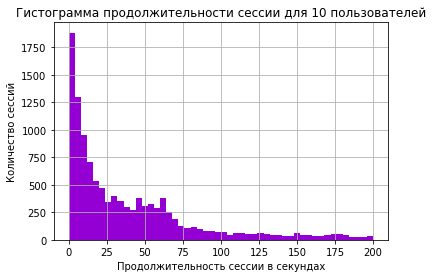

In [28]:
ax = train_data_10users['session_timespan'].hist(bins=50, range=(0,200), color='darkviolet')
ax.set(xlabel='Продолжительность сессии в секундах', 
       ylabel='Количество сессий', 
       title='Гистограмма продолжительности сессии для 10 пользователей')
pass

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

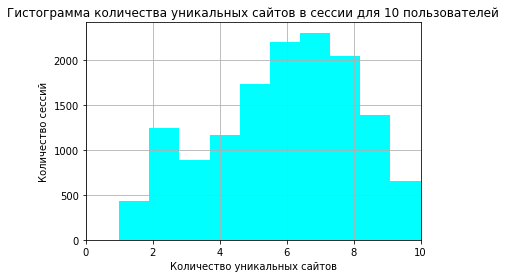

In [29]:
ax = train_data_10users['#unique_sites'].hist(bins=10, color='aqua')
ax.set(xlabel='Количество уникальных сайтов', 
          ylabel='Количество сессий', 
          title='Гистограмма количества уникальных сайтов в сессии для 10 пользователей',
          xlim=[0, 10])
pass

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (#unique_sites) для каждого из 10 пользователей по отдельности. Используйте subplots, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (color_dic). Подпишите оси по-русски в каждой из 10 гистограмм**

Гистограммы количества уникальных сайтов в сессии для каждого пользователя


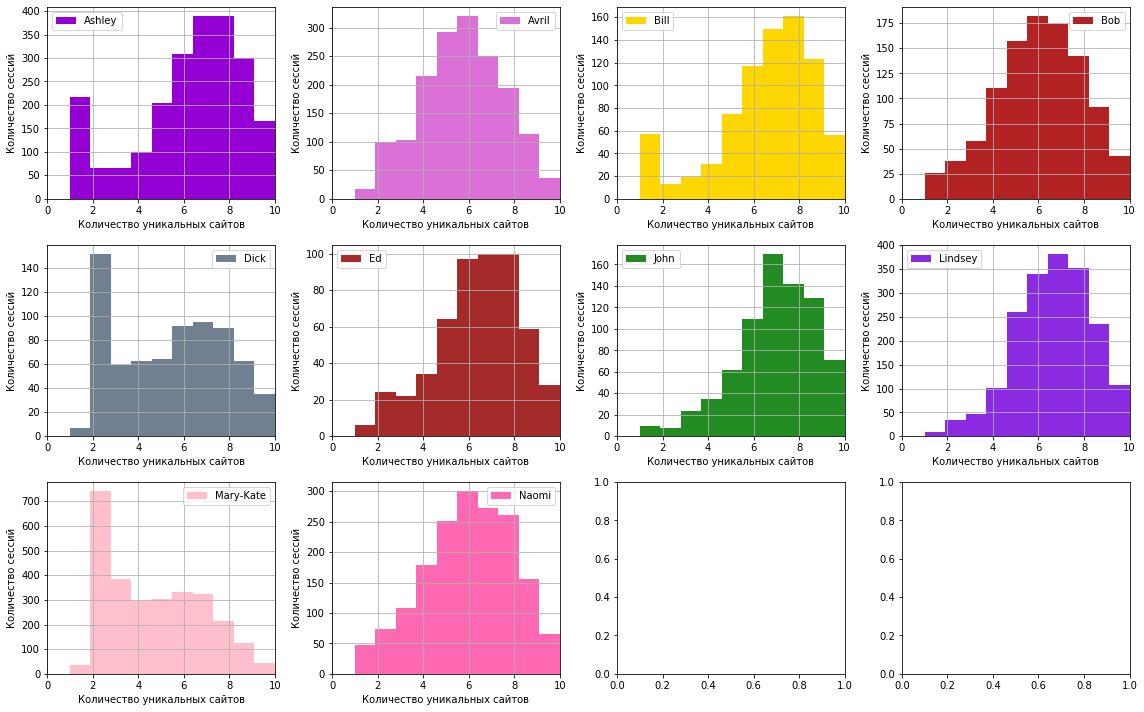

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')):
    sub_df['#unique_sites'].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user)
    axes[idx // 4, idx % 4].set(xlabel='Количество уникальных сайтов', 
                                ylabel='Количество сессий',
                                xlim=[0, 10])
    axes[idx // 4, idx % 4].legend()
fig.tight_layout()
print('Гистограммы количества уникальных сайтов в сессии для каждого пользователя')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

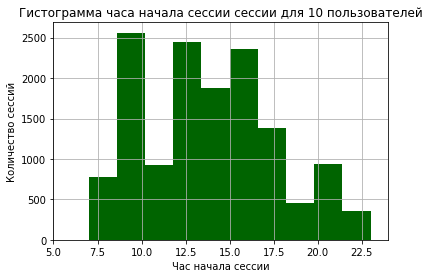

In [31]:
bins=len(pd.unique(train_data_10users['start_hour']))
plot3 = train_data_10users['start_hour'].hist(color='darkgreen')
plot3.set(xlabel='Час начала сессии', 
          ylabel='Количество сессий', 
          title='Гистограмма часа начала сессии сессии для 10 пользователей',
          xlim=[5, 24])
pass

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

Гистограммы часа начала сессии для каждого пользователя


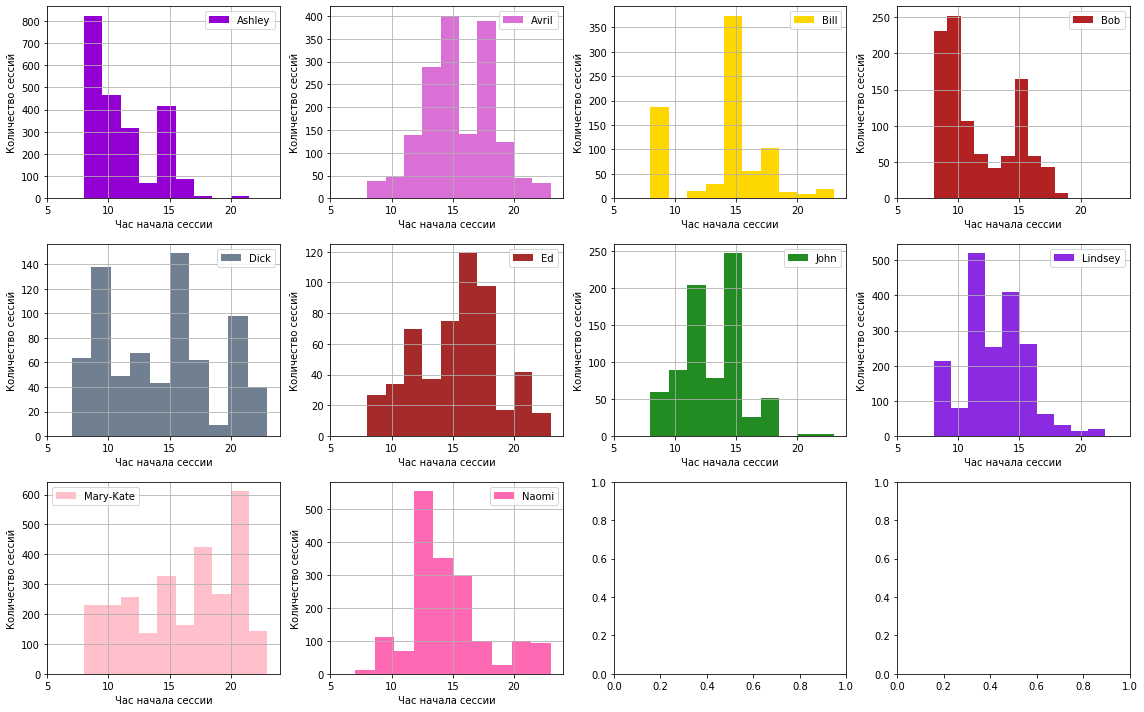

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    sub_df['start_hour'].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user)
    axes[idx // 4, idx % 4].set(xlabel='Час начала сессии', 
                                ylabel='Количество сессий',
                                xlim=[5, 24])
    axes[idx // 4, idx % 4].legend()
fig.tight_layout()
print('Гистограммы часа начала сессии для каждого пользователя')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

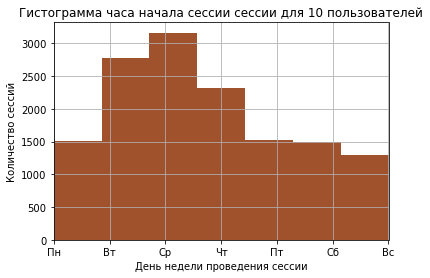

In [18]:
plot4 = train_data_10users['day_of_week'].hist(color='sienna', bins=7)
plot4.set(xlabel='День недели проведения сессии', 
          ylabel='Количество сессий', 
          title='Гистограмма часа начала сессии сессии для 10 пользователей',
          xticks = [0, 1, 2, 3, 4, 5, 6],
          xticklabels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'],
          xlim=[0, 6])
pass

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

Гистограммы дня недели начала сессии для каждого пользователя


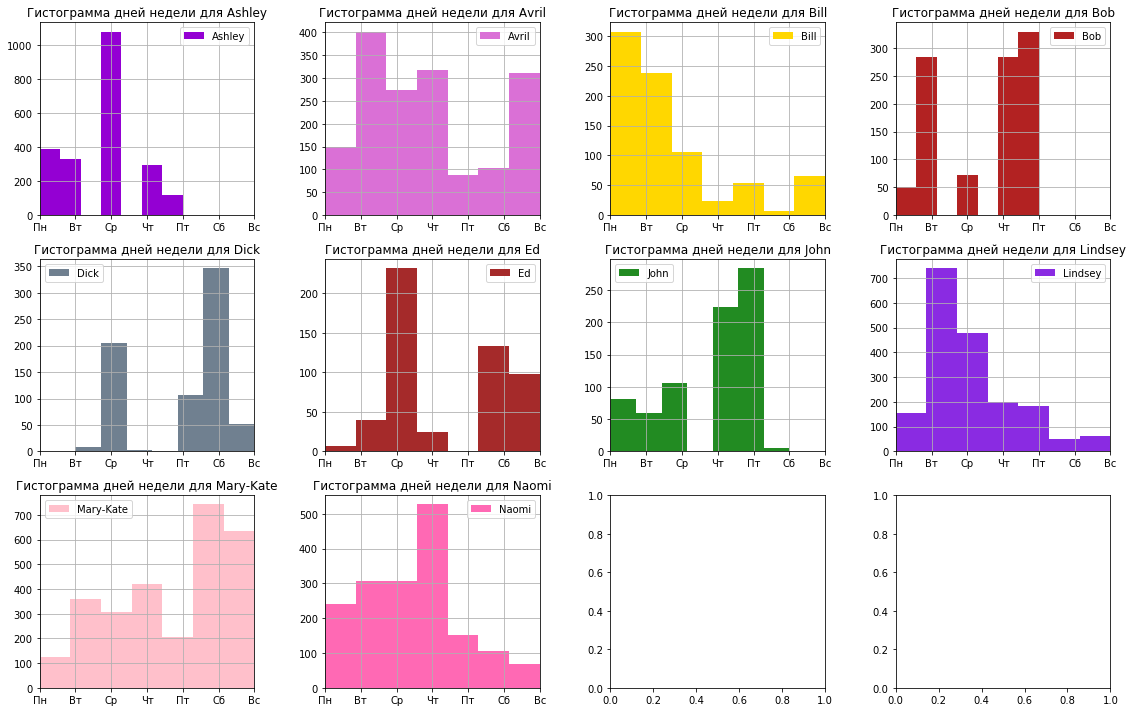

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    sub_df['day_of_week'].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user, bins=7)
    axes[idx // 4, idx % 4].set(title='Гистограмма дней недели для {}'.format(user),
                                xticks = [0, 1, 2, 3, 4, 5, 6],
                                xticklabels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'],
                                xlim=[0, 6])
    axes[idx // 4, idx % 4].legend()
fig.tight_layout()
print('Гистограммы дня недели начала сессии для каждого пользователя')

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

* Во-первых, следует отметить, что распределения количества уникальных сайтов в сессии для каждого пользователя имеют характер, схожий с распределением, построенным по совокупности пользователей.
* Во-вторых, гистограммы распределений начала пользовательских сессий для существенно различаются между пользователями.
* В-третьих, гистограммы распределений днеё недели начало пользовательской сесси также не имеют явного сходства между пользователями.

Остальные особенности распределений для каждого пользователя представлены в таблице ниже.

|  |Количество уникальных сайтов|Час начала сессии|День недели начала|
|--|----------------------------|-----------------|------------------|
|Ashley|Распределение имеет пик в районе 7, также значительное количество сессий состоят из посещения одного сайта|Распределение имеет пик в районе 8-9 часов, затем идёт на спад, ещё один пик в 15|Основная активность в будни с пиком в среду|
|Avril|Распределение имеет пик в районе 6 (похоже на нормальное)|Пиковая активность в 14-15 и в 17-18 часов|Основная активность со вторника по четверг и воскресенье|
|Bill|Распределение имеет пик в районе 8, также значительное количество сессий состоят из посещения одного сайта|Ярко выраженные пики в 8 и 15 часов|Наибольшая активность в понедельник и вторник|
|Bob|Распределение имеет пик в районе 6|Пики активности с 8 до 10 часов и в 15 часов|Основная активность в будни с пиками во вторник четверг и пятницу|
|Dick|Преобладающее количество сессий состоят из двух сайтов, второй (менее значительный) пик распределения в районе 7|Достаточно равномерная активность, пики в районе 9:30, 15:30 и 20:30|Основная активность в понедельник пятницу и субботу|
|Ed|Размазанный пик распределения от 6 до 8 сайтов в сессии|Относительно плавное распределение с пиком в 16 часов и двумя пиками поменьше в 12 и 20:30|Основная активность в среду субботу и воскресенье|
|John|Распределение имеет пик в районе 7|Два ярко выраженных пика активности в 12 и 15 часов|В понедельник и вторник активность приблизительно на одном уровне, затем наинает расти до пятницы включительно|
|Lindsey|Распределение имеет пик в районе 7 (чуть более симметрично, чем предыдущее)|Основная активность с 11 до 16 часов с пиками в 11 и 14 (небольшое уселение активности в 8 часов)|Пик активности во вторник, затем идёт на спад до понедельника (через воскресенье)|
|Mary-Kate|Распределение имеет пик в районе 2 и тяжёлый правый хвост|Активность колебательно растёт с 10 до 21 часа (период колебаний около 3 часов)|Равномерная активность в будни, пиковая активность в выходные|
|Naomi|Распределение имеет пик в районе 6|Пик посещаемости в 12:30 затем идёт на спад до 17 часов|В первой половине недели активность равномерная, пик активности в четверг, затем идёт на спад до конца недели|

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [20]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as fo:
    site_freqs = pickle.load(fo)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [21]:
top10_sites = list(site_freqs.keys())[:10]
top10_freqs = [site_freqs[key][1] for key in top10_sites]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

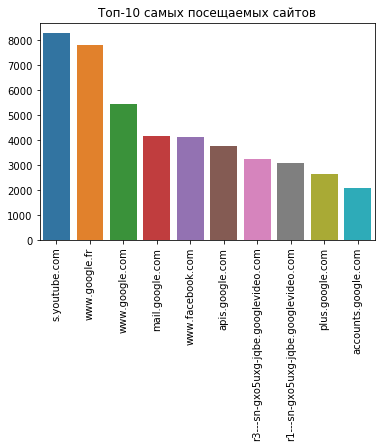

In [22]:
sns.barplot(top10_sites, top10_freqs)
plt.title('Топ-10 самых посещаемых сайтов')
plt.xticks(rotation='vertical')
pass

## Часть 2а. Поиск медианных значений

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [23]:
print('Медианная продолжительности сессии для 10 человек {}'.format(train_data_10users['session_timespan'].median()))

Медианная продолжительности сессии для 10 человек 37.0


**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [24]:
print('Медианный день начала сессии для 10 человек {}'.format(train_data_10users['day_of_week'].median()))

Медианный день начала сессии для 10 человек 2.0


**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [26]:
print('Медианный час начала сессии для 150 человек {}'.format(train_data_150users['start_hour'].median()))

Медианный час начала сессии для 150 человек 13.0


**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [25]:
print('Медианное число уникальных сайтов в сессии для 150 человек {}'.format(train_data_150users['#unique_sites'].median()))

Медианное число уникальных сайтов в сессии для 150 человек 7.0


## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def prepare_train_set_with_fe_ext(path_to_csv_files, site_freq_path, feature_names=None,
                                  session_length=10, window_size=10):
    '''
    Формирование DataFrame'a сессий с столбцами [site1, ..., site{session_length},
    time_diff1, ..., time_diff{session_length - 1}, {...features...}, target]
    здесь:
    siteN -- индекс N-го сайта сессии
    time_diffN -- разница вежду посещением N-го и (N+1)-го сайтов [сек]
    Далее столбцы features следующие:
        session_timespan -- продолжительность сессии [сек]
        #unique_sites -- число уникальных сайтов в сессии
        start_hour -- час начала сессии
        day_of_week -- день недели начала сессии
        timespan_median -- медианное значение продолжительности посещения сайта
        timespan_mean -- среднее значение продолжительности посещения сайта
        daily_aсtivity -- время суток начала сессии (0 -- [7-11], 1 -- [13-16], 2 -- [18-21], 4 -- остальные часы)
        freq_facebook -- количество посещений www.facebook.com в сессии
        timespan_youtube -- суммарное время посещения сайта youtube в сессии
        timespan_mail -- суммарное время посещения сайта mail.google.com в сессии
        freq_googlevideo -- количество посещений сайтов "*googlevideo*"
        freq_google -- количество посещений "www.google.*"
    target -- id пользователя

    :param path_to_csv_files: путь к папке с .csv файлами пользователей
    :param site_freq_path: путь к .pickle файлу со словарём файлов
    :param feature_names: название столбцов формирующегося DataFrame'a
    :param session_length: длина сессии
    :param window_size: ширина окна непересекающейся части сессии
    :return: pandas.DataFrame
    '''
    if feature_names is None:
        feature_names = ['site' + str(i) for i in range(1, session_length + 1)] + \
                        ['time_diff' + str(j) for j in range(1, session_length)] + \
                        ['session_timespan', '#unique_sites', 'start_hour',
                         'day_of_week', 'timespan_median', 'timespan_mean',
                         'daily_aсtivity', 'freq_facebook', 'timespan_youtube',
                         'timespan_mail', 'freq_googlevideo', 'freq_google',
                         'target']

    with open(site_freq_path, 'rb') as fo:
        site_freq = pickle.load(fo)

    facebook_idx = site_freq['www.facebook.com'][0]
    youtube_idx = site_freq['s.youtube.com'][0]
    mail_idxs = [site_freq[key][0] for key in site_freq.keys() if key.find('mail') > -1]
    gvideo_idxs = [site_freq[key][0] for key in site_freq.keys() if key.find('googlevideo') > -1]
    google_idxs = [site_freq[key][0] for key in site_freq.keys() if key.find('www.google.') > -1]

    output = []
    for path in glob(os.path.join(path_to_csv_files, '*.csv')):
        data = pd.read_csv(path)
        username, _ = os.path.splitext(os.path.basename(path))
        user_id = int(username[-4:])

        data_len = len(data)
        for i in range(0, data_len, window_size):
            last_index = min(data_len, i + session_length)
            empty_data_len = i + session_length - last_index
            sub_df = data.iloc[i:last_index]
            sites = list(sub_df.site.apply(lambda x: site_freq[x][0])) + [0 for i in range(empty_data_len)]
            timestamps = sub_df.timestamp.astype(np.datetime64)
            times = [(timestamps.iloc[i+1] - timestamps.iloc[i]).total_seconds() for i in range(len(timestamps)-1)] + \
                    [0 for i in range(empty_data_len)]
            timespan = (timestamps.max() - timestamps.min()).total_seconds()
            unique = (np.unique(sites) > 0).sum()
            start = timestamps.min().hour
            day_of_week = timestamps.min().dayofweek
            timespan_median = np.median(times)
            timespan_mean = np.mean(times)
            if start >= 7 and start <= 11:
                daily_activity = 0
            elif start >= 13 and start <= 16:
                daily_activity = 1
            elif start >= 18 and start <= 21:
                daily_activity = 3
            else:
                daily_activity = 4

            freq_facebook = 0
            timespan_youtube = 0
            timespan_mail = 0
            freq_googlevideo = 0
            freq_google = 0
            for i, site in enumerate(sites):
                if site == facebook_idx:
                    freq_facebook += 1
                    continue
                if site in gvideo_idxs:
                    freq_googlevideo += 1
                    continue
                if site in google_idxs:
                    freq_google += 1
                if i < session_length - 1:
                    if site == youtube_idx:
                        timespan_youtube += times[i]
                        continue
                    if site in mail_idxs:
                        timespan_mail += times[i]
                        continue
            target = user_id

            output.append(sites + times + [timespan, unique, start, day_of_week,
                                           timespan_median, timespan_mean, daily_activity,
                                           freq_facebook, timespan_youtube, timespan_mail,
                                           freq_googlevideo, freq_google,
                                           target])

    output = pd.DataFrame(output, dtype=int)
    output.columns = feature_names

    return output

In [33]:
features = ['session_timespan', '#unique_sites', 'start_hour',
                         'day_of_week', 'timespan_median', 'timespan_mean',
                         'daily_aсtivity', 'freq_facebook', 'timespan_youtube',
                         'timespan_mail', 'freq_googlevideo', 'freq_google',
                         'target']

In [40]:
%%time
new_features_10users = prepare_train_set_fe(os.path.join(PATH_TO_DATA, 'sessions_10users.pkl'), 
                                          site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                          feature_names=features)

(14061, 9)
(14061, 9)
(7461,)


AxisError: axis 1 is out of bounds for array of dimension 1

In [28]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

In [29]:
%%time
new_features_150users = prepare_train_set_with_fe_ext(os.path.join(PATH_TO_DATA, '150users'), 
                                                     site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                                     session_length=10)
new_features_150users['target'] = new_features_150users['target'].map(id_name_dict)

Wall time: 3min 52s


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

**Посмотрим, какая гистограмма выглядит лучше: среднего или медианного времени посещения?**

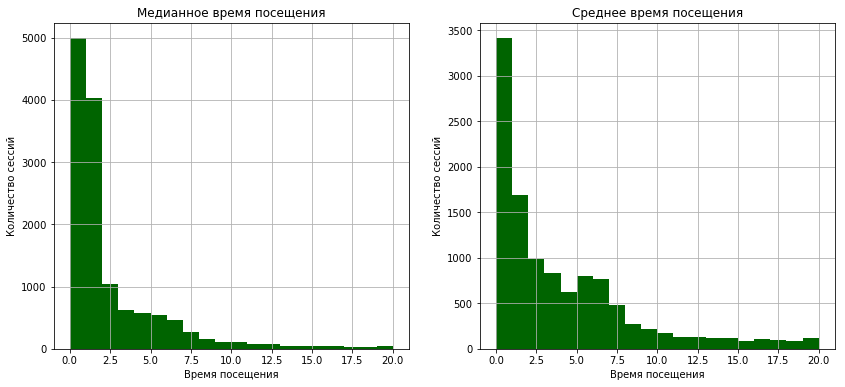

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
new_features_10users['timespan_median'].hist(ax=axes[0], color='darkgreen', bins=20, range=(0,20))
axes[0].set(xlabel='Время посещения', 
            ylabel='Количество сессий', 
            title='Медианное время посещения')
new_features_10users['timespan_mean'].hist(ax=axes[1], color='darkgreen', bins=20, range=(0,20))
axes[1].set(xlabel='Время посещения', 
            ylabel='Количество сессий', 
            title='Среднее время посещения')
pass

Оба распределения имеют достаточно тяжёлые хвосты, а основной пик приходится на минимальное время посещения сайта (< 2 сек). Не уверен, что эти данные как-то помогут при идентификации пользователей.

**Посмотрим на время суток начала сессии. Здесь 0 соответствует часу начала сессии, лежащему в диапазоне [7-11] часов, 1 -- [13-16], 2 -- [18-21], 4 -- остальные часы**

Гистограммы времени суток начала сессии для каждого пользователя


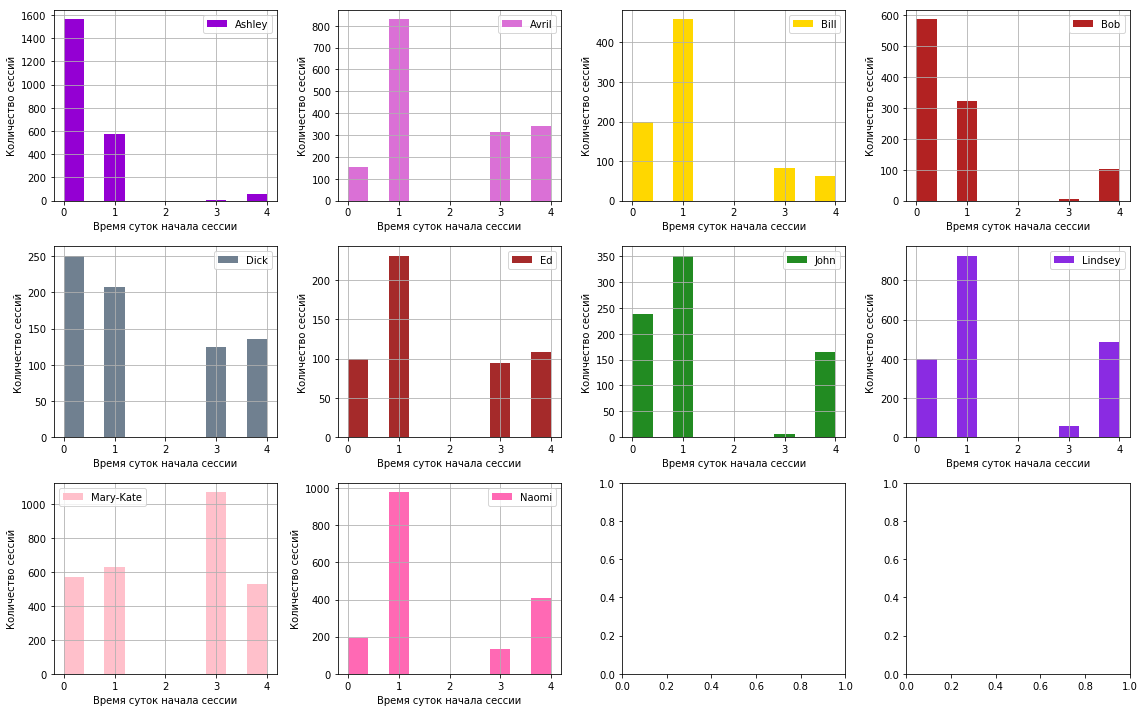

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target')):
    sub_df['daily_aсtivity'].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user)
    axes[idx // 4, idx % 4].set(xlabel='Время суток начала сессии', 
                                ylabel='Количество сессий')
    axes[idx // 4, idx % 4].legend()
fig.tight_layout()
print('Гистограммы времени суток начала сессии для каждого пользователя')

Для большинства пользователей гистограммы получились различными, так, что можно использовать этот признак взамен часа начала сессии.

**Посмотрим на гистограммы посещения сайта facebook**

Гистограммы количества посещений сайта facebook в сессии для каждого пользователя


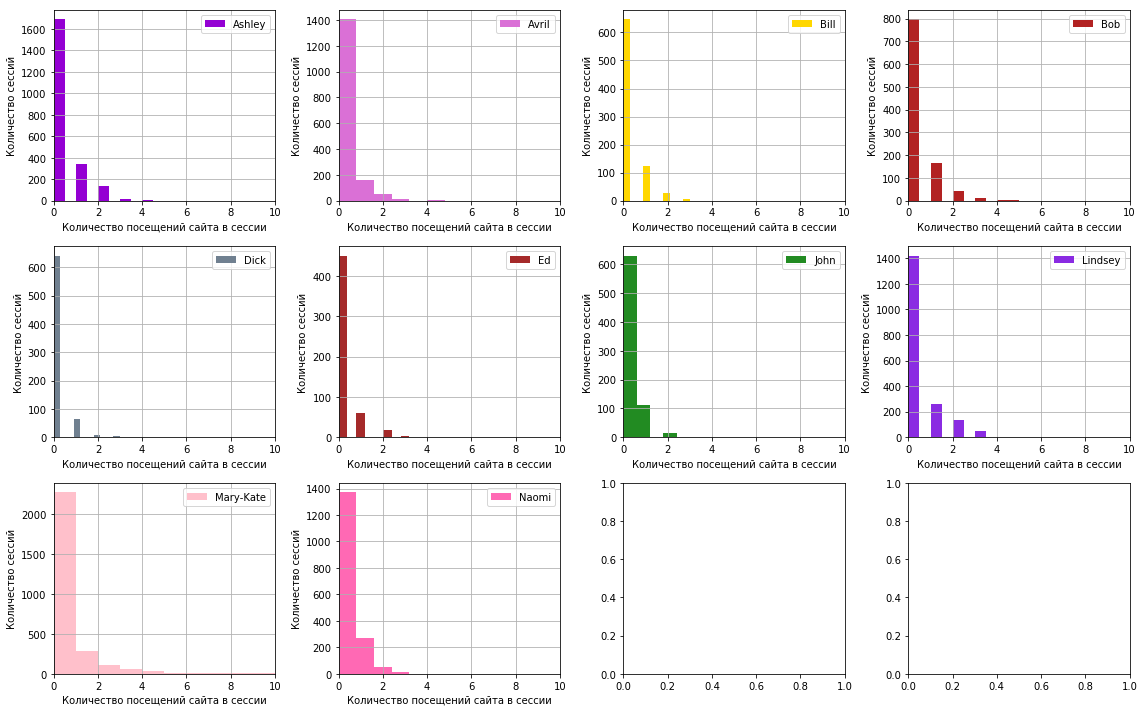

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target')):
    sub_df['freq_facebook'].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user, bins=10)
    axes[idx // 4, idx % 4].set(xlabel='Количество посещений сайта в сессии', 
                                ylabel='Количество сессий',
                                xlim = [0, 10])
    axes[idx // 4, idx % 4].legend()
fig.tight_layout()
print('Гистограммы количества посещений сайта facebook в сессии для каждого пользователя')

Всё-таки facebook чаще посещяют, чем не посещают, тем не менее, для некоторых пользователей гистограммы посещений отличаются от остальных.

**Посмотрим на время посещения youtube, возможно некоторые пользователи предпочитают ролики подлиннее**

Гистограммы суммарного времени посещения сайта youtube в сессии для каждого пользователя


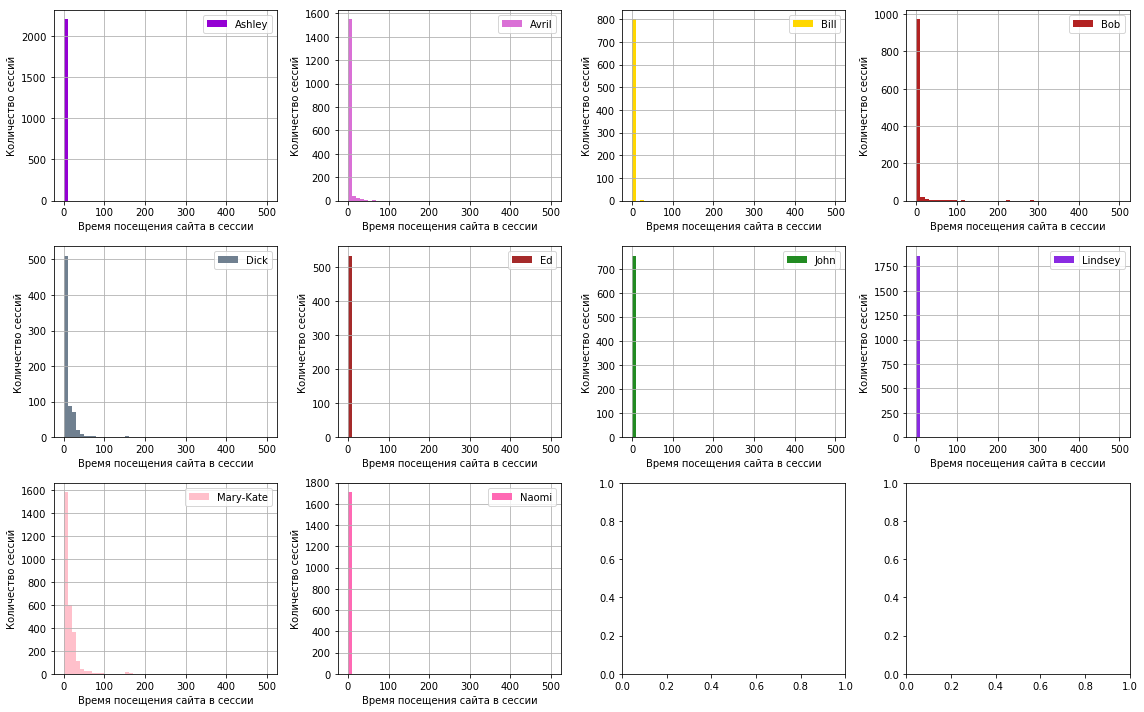

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target')):
     sub_df['timespan_youtube'].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user, bins=50, range=(0,500))
     axes[idx // 4, idx % 4].set(xlabel='Время посещения сайта в сессии', 
                                 ylabel='Количество сессий')
     axes[idx // 4, idx % 4].legend()
fig.tight_layout()
print('Гистограммы суммарного времени посещения сайта youtube в сессии для каждого пользователя')

Некоторые распределения имеют более тяжёлые хвосты. Может помочь в идентификации пользователей.

**Проверим время посещений почты.**

Гистограммы суммарного времени посещения сайтов, сожержащих в названии *mail*, в сессии для каждого пользователя


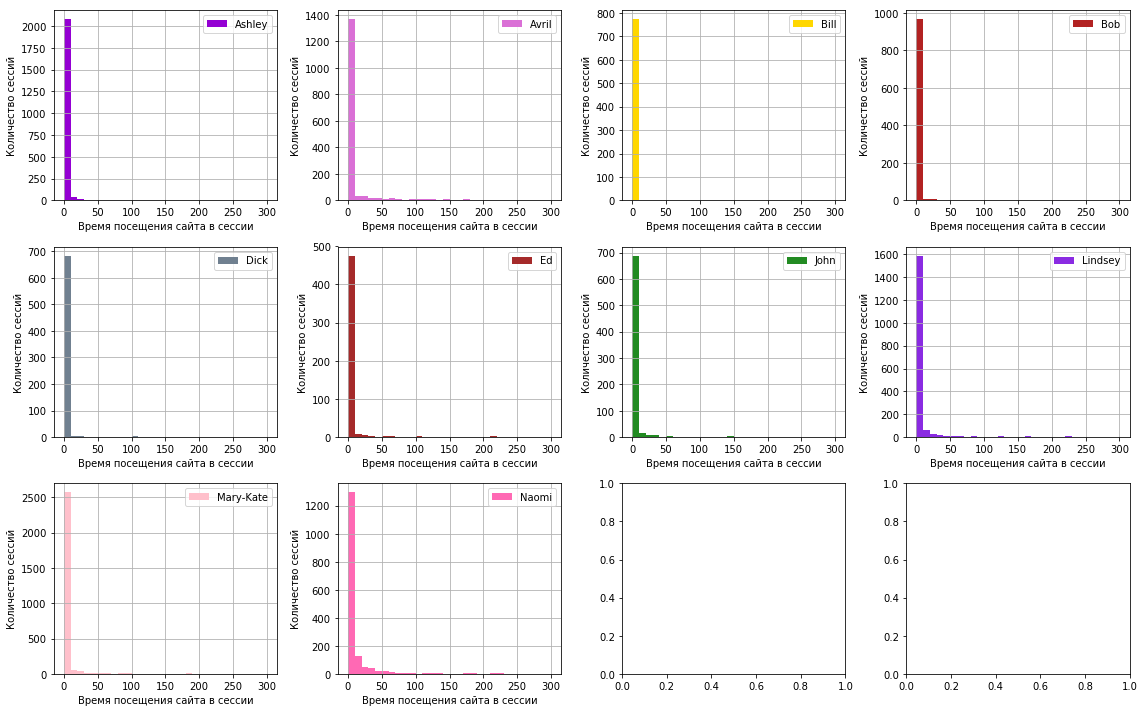

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target')):
    sub_df['timespan_mail'].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user, bins=30, range=(0,300))
    axes[idx // 4, idx % 4].set(xlabel='Время посещения сайта в сессии', 
                                ylabel='Количество сессий')
    axes[idx // 4, idx % 4].legend()
fig.tight_layout()
print('Гистограммы суммарного времени посещения сайтов, сожержащих в названии *mail*, в сессии для каждого пользователя')

Некоторые профили отличаются от остальных более тяжёлыми хвостами. Также можно считать признаком.

**Рассмотрим частоту посещений googlevideo**

Гистограммы количества посещений сайтов, сожержащих в названии *googlevideo*, в сессии для каждого пользователя


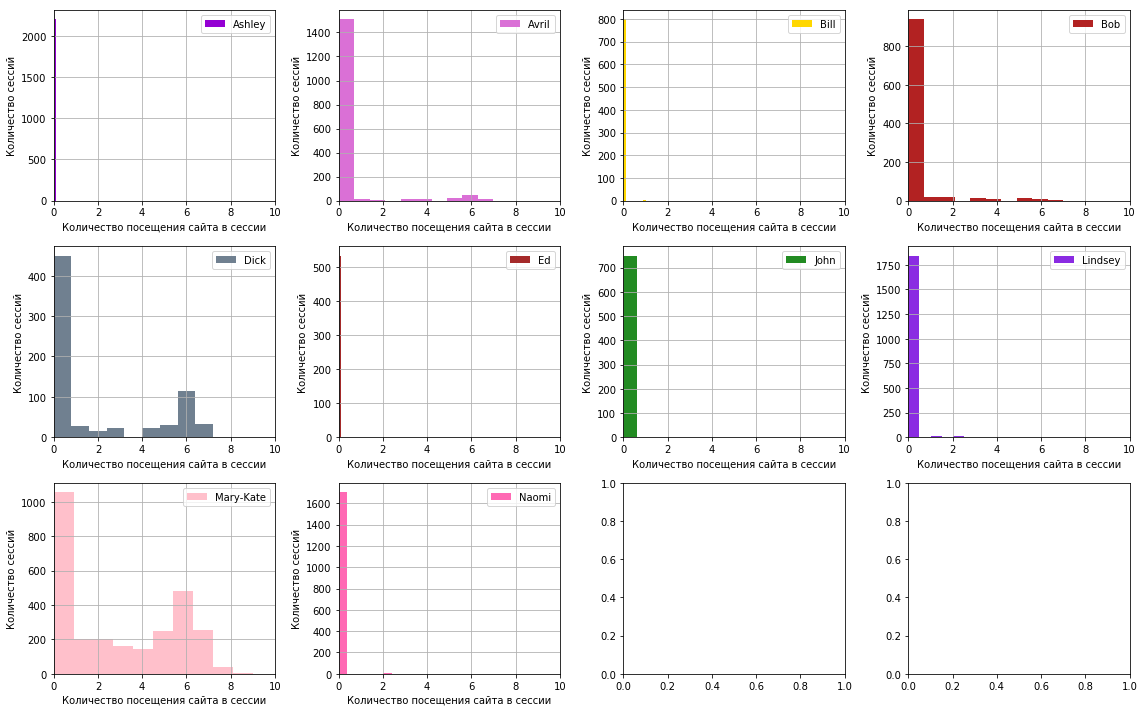

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target')):
    sub_df['freq_googlevideo'].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user, bins=10)
    axes[idx // 4, idx % 4].set(xlabel='Количество посещения сайта в сессии', 
                                ylabel='Количество сессий',
                                xlim=[0, 10])
    axes[idx // 4, idx % 4].legend()
fig.tight_layout()
print('Гистограммы количества посещений сайтов, сожержащих в названии *googlevideo*, в сессии для каждого пользователя')

Некоторые пользователи явно любят позалипать в видосики, хороший признак.

**Частота посещений google**

Гистограммы количества посещений сайтов, сожержащих в названии *www.google.*, в сессии для каждого пользователя


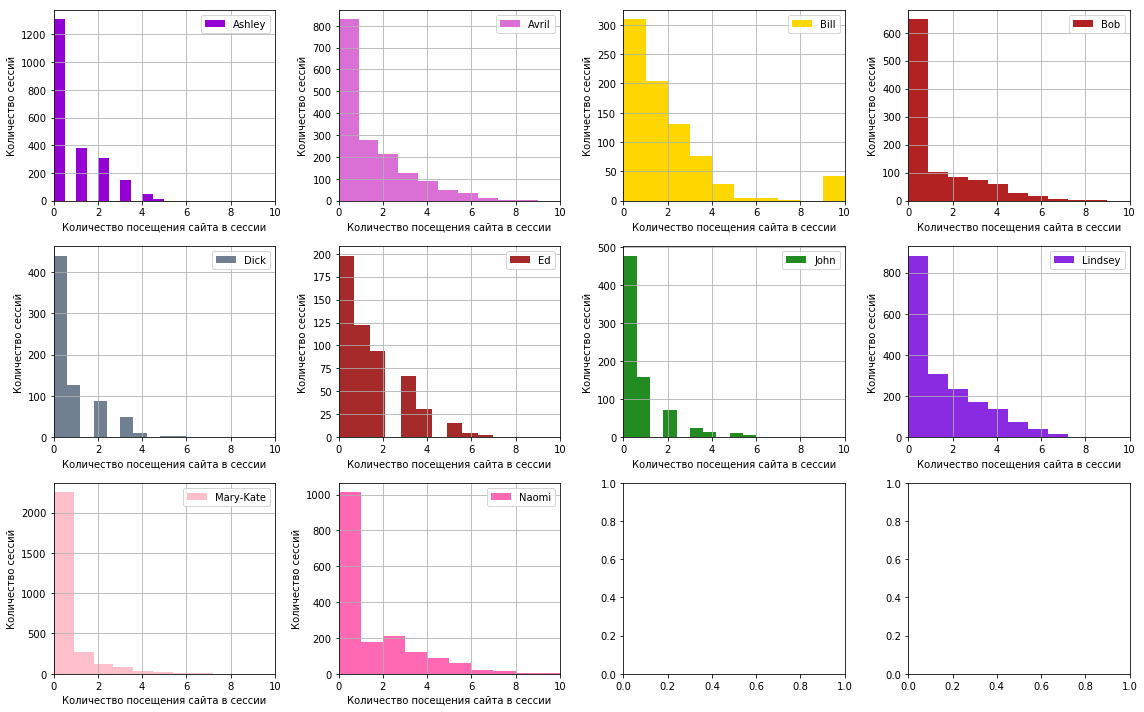

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target')):
    sub_df['freq_google'].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user, bins=10)
    axes[idx // 4, idx % 4].set(xlabel='Количество посещения сайта в сессии', 
                                ylabel='Количество сессий',
                                xlim=[0, 10])
    axes[idx // 4, idx % 4].legend()
fig.tight_layout()
print('Гистограммы количества посещений сайтов, сожержащих в названии *www.google.*, в сессии для каждого пользователя')

А вот гуглом все пользуются практически одинаково.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

Предлагается выбрать следующие признаки:
* Из временных (session_timespan, timespan_median, timespan_mean) Можно выбрать какой-то 1 (или вообще не брать их в учёт), мне больше нравится timespan_mean.
* #unique_sites может помочь определить некоторых пользователей
* start_hour (или его аналог daily_activity) -- хороший признак для определения пользователя
* day_of_week -- также имеет различное распределение между пользователями
* число посещений facebook и google не показывает ярко выраженных различий между пользователями
* время посещения почты и youtube могут помочь при идентификации
* количество посещений googlevideo для некоторых пользователей имеет характер, отличающийся от остальных

In [39]:
cols = ['#unique_sites', 'start_hour', 'daily_aсtivity', 'day_of_week',
        'timespan_youtube', 'timespan_mail', 'freq_googlevideo',
        'target']
selected_features_10users = new_features_10users[cols]
selected_features_150users = new_features_150users[cols]

In [40]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 

**Попробуем t-SNE**

In [41]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [12]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'rb') as selected_features_10users_pkl:
        selected_features_10users = pickle.load(selected_features_10users_pkl)

In [42]:
id_name_dict = dict((name, i) for i, name in enumerate(list(set(selected_features_10users.iloc[:, -1]))))
selected_features_10users['target'] = selected_features_10users['target'].map(id_name_dict)

In [43]:
%%time
sessions = selected_features_10users.iloc[:, :-1]
target = selected_features_10users.iloc[:, -1]
embeddings = TSNE(n_jobs=4).fit_transform(sessions)
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]

Wall time: 1min 15s


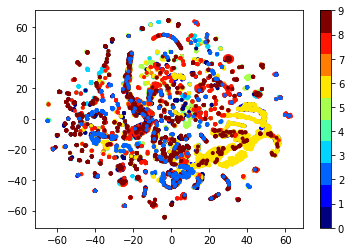

In [44]:
plt.scatter(vis_x, vis_y, c=target, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.show()

Попробуем выкинуть некоторые признаки

In [45]:
%%time
cols = ['#unique_sites', 'daily_aсtivity', 'day_of_week',
        'timespan_mail', 'freq_googlevideo',
        'target']
sessions = selected_features_10users[cols].iloc[:, :-1]
embeddings = TSNE(n_jobs=4).fit_transform(sessions)
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]

Wall time: 1min 21s


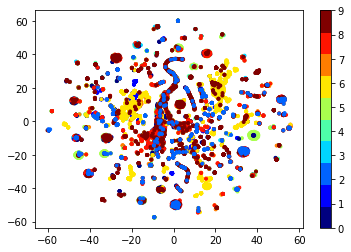

In [46]:
plt.scatter(vis_x, vis_y, c=target, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.show()

В общем, как и обещалось, каша)